# Run analysis for a phagophore rim segment

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import pyvista as pv
from pyvistaqt import BackgroundPlotter

from scipy.spatial import cKDTree
import scipy.signal as sig

# Import custom functions
dir_utilities = Path('../utilities').resolve().as_posix()
if dir_utilities not in sys.path:
    sys.path.insert(0, dir_utilities)

from fitting_functions import fit_curve_spline_oversampled    

from histogram_functions import (histogram_2d_values,
                                 histogram_2d_polydata,
                                 histogram_1d_statistics,
                                 plot_hist1d_std,
                                 get_peaks_histogram_rows_v2)
    
from distance_functions import (point_dist_splinemapping,
                                distance_along_point_array)

from utility_functions import (find_successive_ones,
                               namedtuple_to_dict,
                               dicts_all_equal)

from rim_analysis_functions import (separate_sides_phagophore_rim,
                                    rim_ray_tracing,
                                    bending_energy, 
                                    bending_energy_half_cylinder,
                                    get_extrema_rim_hist,
                                    tipdist_difference_geo_direct_v1)



## Input

In [2]:
# Input file
fname_in = Path('../example_data/rim_analysis/Ph_rim0_.AVV_rh8.vtp')

# Pixel size
pix_size = 1.408

# Plot settings for visualization (specific for example rim)
# camera position
cpos = {'rays': [(-134.96683922358378, 202.6816207812237, 433.94917341928186),
                  (158.31317837682528, 132.64935465070562, 57.45067489896043),
                  (0.7373122621878435, -0.2613407221524428, 0.6229539750031978)], 
    
        'rim0': [(-127.69089655029208, 503.48308402385226, 210.08842469429266),
                  (141.75165891729134, 139.25513593306735, 40.90341928152465),
                  (0.21188554670852192, -0.2784019411531808, 0.9368014059864405)],
        
        'rim1': [(31.768907027913784, 561.9596456193212, 285.8011646641085),
                  (148.79417869024064, 135.74706663654985, 59.46889603869569),
                  (0.11804412133959015, -0.4402499788750957, 0.8900817611419987)]}

window_size_0 = [300,512]

# Dictionary for collecting results
res_dict = {}

# Results dictionary for comparison
fname_compare = fname_in.parent / 'Ph_rim0_results.npy'

# Save output meshes (needed e.g. to make reference mesh)
save_meshes = True
fnames_out_mesh = {label: fname_in.parent / ('{}_mesh_out.vtp'.format(label)) for label in ['rim', 'mid_surf']}

## Load & process pycurv mesh

### Load data

In [3]:
# Load mesh
curv_mesh = pv.read(fname_in)

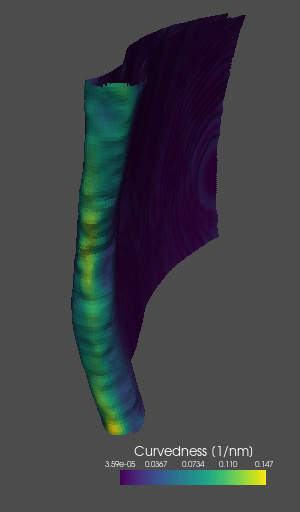

In [4]:
# Plot the mesh 

# Plot rim with curvedness
p1 = pv.Plotter(notebook=True, window_size=window_size_0)
p1.add_mesh(curv_mesh, scalars='curvedness_VV', cmap='viridis', show_scalar_bar=False)
p1.add_scalar_bar(title='Curvedness [1/nm]')
p1.camera_position = cpos['rim0']

_ = p1.show()

### Separate the sides

In [5]:
kappa_1_limit = 0.08 # Gets very extended tip region
smooth_factor_tip_0 = 50 # Light smooth factor used for adjusting tip points and distance along tip
smooth_factor_tip_1 = 500 # Strong smooth factor used for distance to tip

# Separate tip & sides of the phagophore rim
tip, side0, side1, mid_surf, sides_extra, mid_surf_info = separate_sides_phagophore_rim(curv_mesh, 
                                                                                            k1_limit_initial=kappa_1_limit, 
                                                                                            tip_spline_smooth=smooth_factor_tip_0,
                                                                                            pix_size=pix_size, 
                                                                                            plot_sides_initial=False, 
                                                                                            plot_sides_final=False,
                                                                                            clean_sides_clustering=True,
                                                                                            mid_surf_pol_order=3)

# Get tip KDTree and initial tip spline
tree_tip = sides_extra.tree_tip
# tip_spline: follows tip points more closely, used for distance along spline
tip_spline = sides_extra.tip_spline

# tip_spline_smooth: strongly smoothed tip spline, used for mapping points on spline
if smooth_factor_tip_0 == smooth_factor_tip_1:
    tip_spline_smooth = tip_spline
else:
    tip_spline_smooth = fit_curve_spline_oversampled(tip.points, smooth_factor=smooth_factor_tip_1, 
                                                     oversample_factor=2) 
    
# Save tip/side0/side1 ids also in curv_mesh
curv_mesh['point_type'] = np.ones_like(curv_mesh['kappa_1'])*-1

for i, ids in zip([0,1,2], (side0.ids, side1.ids, tip.ids)):
    curv_mesh['point_type'][ids] = i
    
# Save parameters in results dictionary
res_dict['processing'] = {'tip_kappa_1_limit': kappa_1_limit,
                          'tip_smooth_factor_0': smooth_factor_tip_0, 
                          'tip_smooth_factor_1': smooth_factor_tip_1}
# Save tip splines
res_dict['data'] = {'tip_spline': tip_spline,
                    'tip_spline_smooth': tip_spline_smooth}

Moving 0 points from side 0 to side 1, and 0 points from side 1 to side 0.


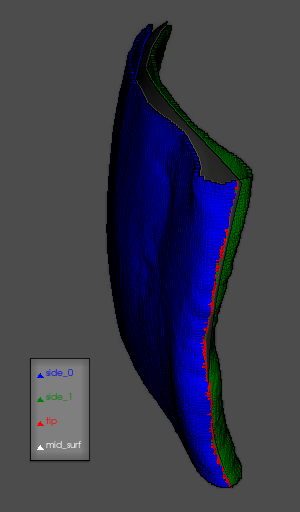

In [6]:
# Plot the point separation in a pv.Plotter
p2 = pv.Plotter(notebook=True, window_size=window_size_0)
p2.enable_eye_dome_lighting()
p2.add_mesh(side0.points, color='blue', label='side_0')
p2.add_mesh(side1.points, color='green', label='side_1')
p2.add_mesh(tip.points, color='red', label='tip')

p2.add_mesh(mid_surf, color='white', label='mid_surf')
p2.add_legend()
p2.legend.SetPosition(0.1,0.1) # move legend using vtk command
p2.camera_position = cpos['rim1']

_ = p2.show()

## Intermembrane distances

### Get intermembrane distances through ray tracing

In [7]:
# Perform ray tracing with Pyvista's multi ray trace
ray_trace = rim_ray_tracing(curv_mesh, mid_surf, side0.ids, side1.ids)
    
# Write out fields needed for later operations
ray_distances = ray_trace.ray_distances
ray_mid_ids = ray_trace.ray_mid_ids 
ray_mid_points = ray_trace.ray_mid_points

# For plotting: get ray vectors
ray_vectors = ray_trace.side1_points - ray_trace.side0_points

# Save in results
res_dict['im_dist'] = {'ray_trace': ray_trace}

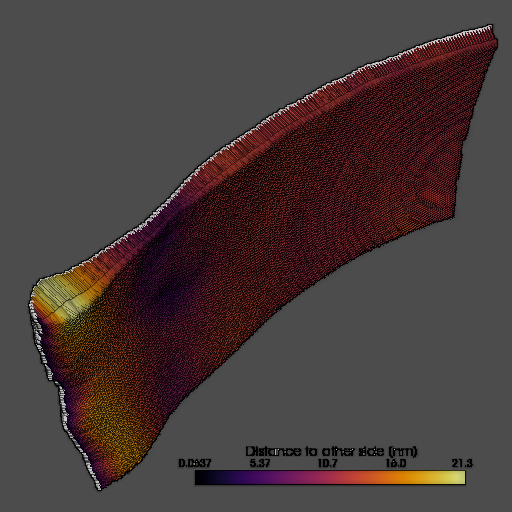

In [8]:
# Plot ray tracing vectors
p3 = pv.Plotter(notebook=True, window_size=[512,512])
p3.enable_eye_dome_lighting()

p3.add_mesh(ray_trace.side0_points, color='white')
p3.add_arrows(ray_trace.side0_points, ray_vectors, stitle='Distance to other side [nm]', cmap='inferno')

p3.camera_position = cpos['rays']

_ = p3.show()


### Calculate position w.r.t. the tip for all points

In [9]:
# Calculate distances with respect to the tip for making histograms

# Distance to tip

# Get correction value for difference between geodesic and direct distance
mid_surf['dist_diff'], mid_surf_ids = tipdist_difference_geo_direct_v1(mid_surf, mid_surf_info, tip.points, tree_tip)

# Get distance to tip and ID of corresponding tip point for all mid points (use strongly smoothed spline for mapping)
dist_mid_tip, idx_mid_tip = point_dist_splinemapping(mid_surf.points, tip.points, tip_spline_smooth) 
mid_surf['dist_to_tip'] =  dist_mid_tip + mid_surf['dist_diff']


# Distance along the tip spline

# Get the distances along the spline (lightly smoothed)
spline_distances = distance_along_point_array(tip_spline) # Cumulative distance along spline
# Find nearest neighbors of tip points in spline    
tree_spline = cKDTree(tip_spline)
_, tip_ids_spline = tree_spline.query(tip.points) 
# Assign distances to the tip points
dist_along_tip = spline_distances[tip_ids_spline]


In [10]:
# For histogram of ray tracing results: get dist to/along tip for all ray mid points
dist_raymid_tip = mid_surf['dist_to_tip'][ray_mid_ids]
idx_raymid_tip = idx_mid_tip[ray_mid_ids]

dist_along_tip_rays = dist_along_tip[idx_raymid_tip]

# Also get values for histogram for all points (not only ray trace points)
# Map all points to corresponding middle surface points
tree_mid = cKDTree(mid_surf.points)
dist_all_mid, idx_all_mid = tree_mid.query(curv_mesh['xyz'])

curv_mesh['mid_id'] = idx_all_mid
curv_mesh['dist_to_tip_orth'] = dist_mid_tip[idx_all_mid]
curv_mesh['dist_along_tip'] = dist_along_tip[idx_mid_tip[idx_all_mid]]

### Histograms of intermembrane distance

In [11]:
# Generate histograms of membrane distance binned by distance to tip and distance along spline

# Bin steps
bin_step_dist = pix_size # Default: pix_size
bin_step_tip = 2*pix_size# Default: 2*pix_size 
print('Making histogram with binning step of {} nm for distance to tip, and {} nm along tip.'.format(bin_step_dist, bin_step_tip))

bin_steps_xy = (bin_step_dist, bin_step_tip)

Making histogram with binning step of 1.408 nm for distance to tip, and 2.816 nm along tip.


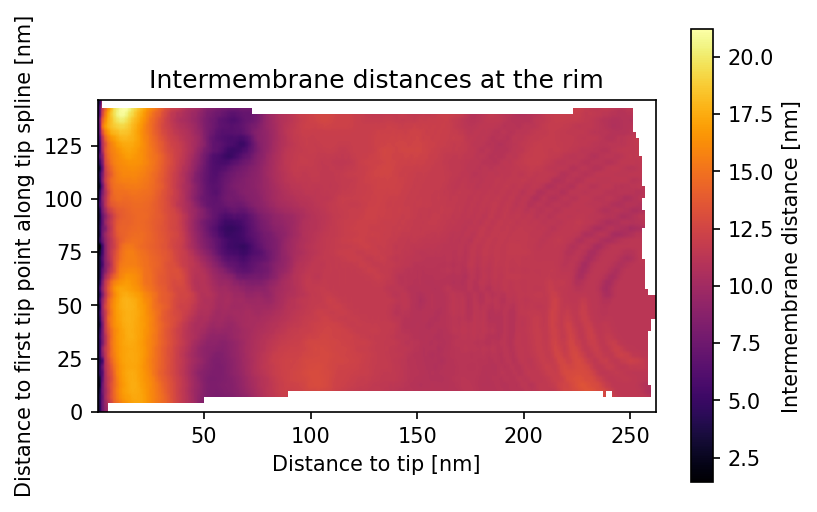

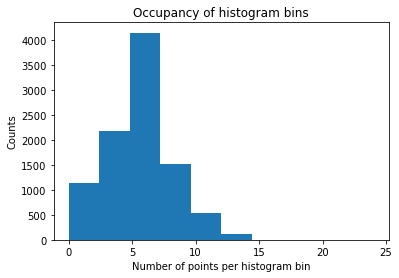

In [12]:
# 2D Histogram of intermembrane distance 

# Generate histogram
H, H_counts, extent_hist, bins_dist, bins_tip = histogram_2d_values(dist_raymid_tip, dist_along_tip_rays, 
                                                                    values=ray_distances, 
                                                                    bin_steps=bin_steps_xy, return_bins=True)
# Calculate middle values of bins
bin_dist_middles = 0.5*(bins_dist[:-1] + bins_dist[1:])
bin_tip_middles = 0.5*(bins_tip[:-1] + bins_tip[1:])

# Save parameters and histogram plot
res_dict['processing'].update({'hist_bin_step_dist': bin_step_dist,
                               'hist_bin_step_tip': bin_step_tip,
                               'hist_bin_mean_count': np.mean(H_counts.flatten()),
                               'hist_empty_bin_n': len(np.where(H_counts == 0)[0]),
                               'hist_empty_bin_frac': len(np.where(H_counts == 0)[0]) / (H.shape[0]*H.shape[1])})

# Plot
fig, ax = plt.subplots(dpi=150)
im = ax.imshow(H.T, origin='lower', extent=extent_hist, aspect='equal', cmap='inferno')   # Note: histogram has shape nx x ny, therefore needs to be transposed
plt.colorbar(im, label='Intermembrane distance [nm]')
ax.set_ylabel('Distance to first tip point along tip spline [nm]')
ax.set_xlabel('Distance to tip [nm]')
ax.set_title('Intermembrane distances at the rim')
plt.show()

# Plot counts in histogram bins
fig1, ax1 = plt.subplots()
ax1.hist(H_counts.flatten())
ax1.set_xlabel('Number of points per histogram bin')
ax1.set_ylabel('Counts')
ax1.set_title('Occupancy of histogram bins')
plt.show()

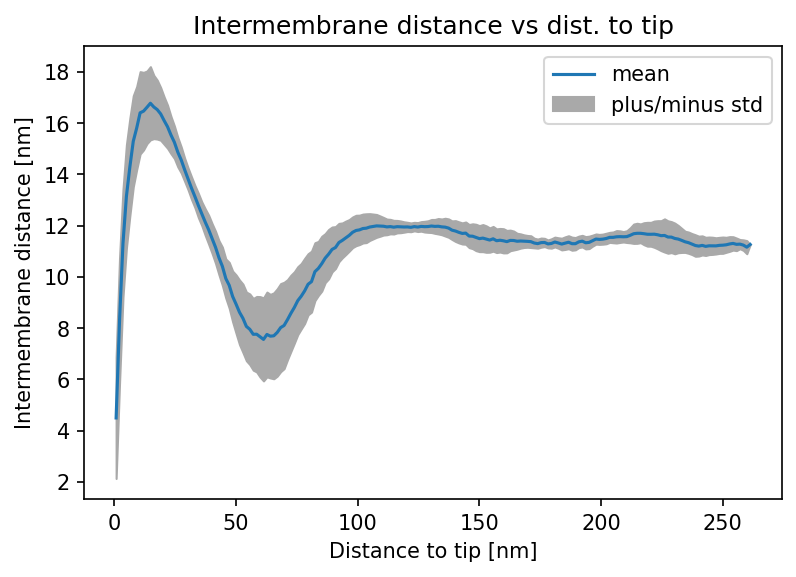

In [13]:
# 1D Histogram of intermembrane distance 

H1d, H1d_bin_edges, H1d_bin_ids = histogram_1d_statistics(dist_raymid_tip, values=ray_distances, 
                                                          bin_steps=bin_step_dist, statistics='basic')

fig, ax = plot_hist1d_std(bin_dist_middles, H1d, xlabel='Distance to tip [nm]', ylabel='Intermembrane distance [nm]',
                          title='Intermembrane distance vs dist. to tip', ax=None, dpi=150)

### Find extrema in intermembrane distance histogram

In [14]:
# Preparations for finding extrema

# BACK AREA definition
# Define a mean distance value for the back part of the rim
back_cutoff_dist = 120 # cutoff distance in nm
back_cutoff_id = np.searchsorted(bins_dist, back_cutoff_dist, side='right') - 1 # np.searchsorted gives first index where value is larger than the query

# Calculate mean and std of ray distance in the back using original data (otherwise std will be off)
ids_back = np.where(dist_raymid_tip > back_cutoff_dist)[0]
imdist_back_all = ray_distances[ids_back]
imdist_back_mean = np.mean(imdist_back_all)
imdist_back_std = np.std(imdist_back_all)

print("Intermembrane distance in the back: mean {:.2f} nm, std {:.2f} nm.".format(imdist_back_mean, imdist_back_std))


# Only look at histogram rows (H columns-> rows) that are complete. 
# Work with transposed arrays (more intuitive)
H0 = H.T.copy()

# Filter for rows to evaluate: Find first occurence of two successive empty bins --> should be in the second half of the histogram
H0_cut_ids = find_successive_ones(H0.mask, 2)

# Only look at rows where first occurence of two empty bins is after half of the distance to the back
min_full_bins_to_back = 0.5
eval_row_ids = np.where(H0_cut_ids > min_full_bins_to_back*back_cutoff_id)[0]

H1 = H0[eval_row_ids,:] # Extract relevant rows
H1_counts = H_counts.T[eval_row_ids,:]

# Also get relevant bin tip middles
bin_tip_middles_H1 = bin_tip_middles[eval_row_ids]

# Save relevant parameters and results --------------------------------------------------
res_dict['processing']['hist_back_cutoff_dist'] = back_cutoff_dist
res_dict['processing']['hist_min_full_bins_to_back'] = min_full_bins_to_back

# Save RESULTS: intermembrane distance in the back
res_dict['im_dist']['back'] = {}
for key in ['imdist_back_mean', 'imdist_back_std', 'imdist_back_all', 'back_cutoff_dist']:
    res_dict['im_dist']['back'][key] = locals()[key]

Intermembrane distance in the back: mean 11.52 nm, std 0.42 nm.


#### Global extrema

In [15]:
# Finding extrema part 1: Simply take global max and global min leaving out tip
global_extrema = get_extrema_rim_hist(H1, back_cutoff_id, bins_dist, bin_step_dist, verbose=False)

# Prepare values to save
extrema_results = {}
for peaktype, subdict in global_extrema.items():
    for name, abbr, full_name in zip(['values', 'pos_nm'], ['_val_', '_pos_'], ['value', 'position']):
        out_key_mean = peaktype + abbr + 'mean_nm'
        out_key_std = peaktype + abbr + 'std_nm'
                              
        extrema_results[out_key_mean] = np.mean(subdict[name])
        extrema_results[out_key_std] = np.std(subdict[name])
        
        print('Global {} {}: {:.1f} ± {:.1f} nm'.format(peaktype, full_name, 
                                                            extrema_results[out_key_mean], extrema_results[out_key_std]))


Global max value: 16.9 ± 1.5 nm
Global max position: 15.5 ± 2.4 nm
Global min value: 7.2 ± 1.6 nm
Global min position: 61.8 ± 6.2 nm


#### Find peaks

In [16]:
# Finding extrema part 2: peak maxima & minima
# Savitzky-Golay parameters: half window length and polynomial order
win_M = 4
SG_win_len = int(2*win_M + 1)
SG_pol_order = 2

# Peak parameters
peak_dist = 5*pix_size
peak_prom = pix_size
peak_width = 5

peaks, peak_props_rows, n_peak_rows = get_peaks_histogram_rows_v2(H1, SG_win_len=SG_win_len, SG_pol_order=SG_pol_order,
                                                                  peak_dist=peak_dist, peak_prom=peak_prom,
                                                                  peak_width=peak_width, n_cut_empty_bins=2)

# Store relevant peak parameters into a new dict named peak_results
n_H1_rows = H1.shape[0]
peak_results = {}
for key, subdict in peaks.items():
    # Peak type: max or min
    peaktype = key[:3]
    # Get number of peaks & fraction of rows with peak
    n_peaks = len(subdict['row_ids'])
    peak_results[peaktype + '_n_peaks'] = n_peaks
    peak_results[peaktype + '_frac_rows_with_peaks'] = n_peaks / n_H1_rows
    print(r'Found {} {} peaks in {} rows. This corresponds to {:.1f} % of the histogram rows.'.format(n_peaks, peaktype, n_H1_rows, 100*n_peaks / n_H1_rows))
    # Values (take original values) and positions
    values = subdict['values_orig']
    
    
    if np.all(np.isnan(values)):
        print('All {} peaks correspond to empty bins, skipping..'.format(peaktype))   
        peak_results[peaktype + '_n_peaks'] = 0
        peak_results[peaktype + '_frac_rows_with_peaks'] = 0
        continue
    
    # Get positions
    pos = bin_dist_middles[subdict['col_ids']]
    
    if np.any(np.isnan(values)):
        print('{} {} peaks left out from value calculation because they correspond to empty bins.'.format(np.sum(np.isnan(values)), peaktype))                
        pos = pos[~np.isnan(values)]
        values = values[~np.isnan(values)]
        
        
    # Save positions and number of peaks also in the peaks[key] subdict itself
    peaks[key]['positions_nm'] = pos
    peaks[key]['n_peaks'] = n_peaks
    
    for d, abbr, full_name in zip([values, pos], ['_val_', '_pos_'], ['value', 'position']):
        out_key_mean = peaktype + abbr + 'mean_nm'
        out_key_std = peaktype + abbr + 'std_nm'
                              
        peak_results[out_key_mean] = np.mean(d)
        peak_results[out_key_std] = np.std(d)
        
        print('Peak {} {}: {:.1f} ± {:.1f} nm'.format(peaktype, full_name, np.mean(d), np.std(d)))




Found 49 max peaks in 49 rows. This corresponds to 100.0 % of the histogram rows.
Peak max value: 16.9 ± 1.6 nm
Peak max position: 15.3 ± 2.3 nm
Found 48 min peaks in 49 rows. This corresponds to 98.0 % of the histogram rows.
Peak min value: 7.2 ± 1.6 nm
Peak min position: 61.8 ± 6.8 nm


#### Save extrema results

In [17]:
# Save results
# using easier way to save variables: a=1 --> locals()['a']=1
res_dict['processing']['find_peaks'] = {}

for key in ['SG_win_len', 'SG_pol_order', 'peak_dist', 'peak_prom', 'peak_width']:
    res_dict['processing']['find_peaks'][key] = locals()[key]

for key in ['global_extrema', 'extrema_results', 'peaks', 'peak_results']:
    res_dict['im_dist'][key] = locals()[key]

#### Plot extrema

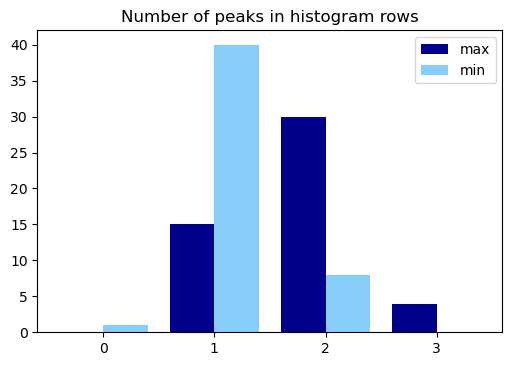

In [18]:
# Plot histogram for number of peaks

max_n_peaks = max(n_peak_rows['max']+n_peak_rows['min'])
bins = np.arange(-0.5, max_n_peaks+1.5, 1)
fig, ax = plt.subplots(dpi=100)
ax.hist([n_peak_rows['max'], n_peak_rows['min']], bins=bins, label=['max', 'min'], color=['darkblue', 'lightskyblue'])
ax.xaxis.set_ticks(bins[:-1]+0.5)
ax.legend()
ax.set_title('Number of peaks in histogram rows')
plt.show()

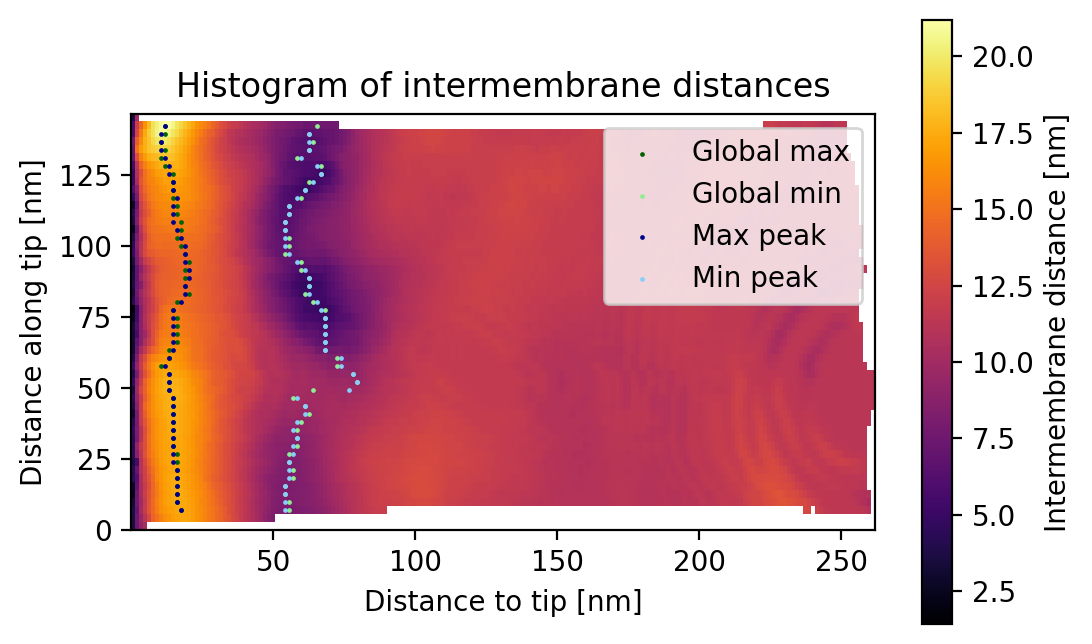

In [19]:
# Compare results from different peak finding strategies

# Generate positions for scattering
hist_positions = {'A_max': np.c_[bin_tip_middles_H1, bin_dist_middles[global_extrema['max']['ids']]],
                  'A_min': np.c_[bin_tip_middles_H1, bin_dist_middles[global_extrema['min']['ids']]],
                  'C_max': np.c_[bin_tip_middles_H1[peaks['max_1']['row_ids'].astype(int)], bin_dist_middles[peaks['max_1']['col_ids'].astype(int)]],
                  'C_min': np.c_[bin_tip_middles_H1[peaks['min_1']['row_ids'].astype(int)], bin_dist_middles[peaks['min_1']['col_ids'].astype(int)]]}

# Plot histograms with peak positions

fig, ax = plt.subplots(dpi=200)
im = ax.imshow(H.T, origin='lower', extent=extent_hist, aspect='equal', cmap='inferno')
plt.colorbar(im, label='Intermembrane distance [nm]')
ax.set_ylabel('Distance along tip [nm]')
ax.set_xlabel('Distance to tip [nm]')

colors = {'A_max': 'darkgreen', 'A_min': 'lightgreen', 'C_max': 'darkblue', 'C_min': 'lightskyblue'}
labels = {'A_max': 'Global max', 'A_min': 'Global min', 'C_max': 'Max peak', 'C_min': 'Min peak'}
for i, key in enumerate(hist_positions.keys()):
    ax.scatter(hist_positions[key][:,1], hist_positions[key][:,0], color=colors[key], s=0.5, label=labels[key])

ax.legend(loc='upper right')
ax.set_title('Histogram of intermembrane distances')
plt.show()

## Curvature analysis

In [20]:
# Trick to get common axis labels
def fig_common_axis_labels(fig, xlabel=None, ylabel=None):
    """Add common x or y axis labels to figure with subplots."""
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    if xlabel is not None: plt.xlabel(xlabel)
    if ylabel is not None: plt.ylabel(ylabel)
    plt.tight_layout()

### 2D histograms

Tip points: Mean kappa_1 is 0.14417213201522827 1/nm, std is 0.024269796907901764 1/nm.
Tip points: Mean kappa_2 is 0.014713622629642487 1/nm, std is 0.017088044434785843 1/nm.
Tip points: Mean curvedness_VV is 0.10316698253154755 1/nm, std is 0.017266523092985153 1/nm.


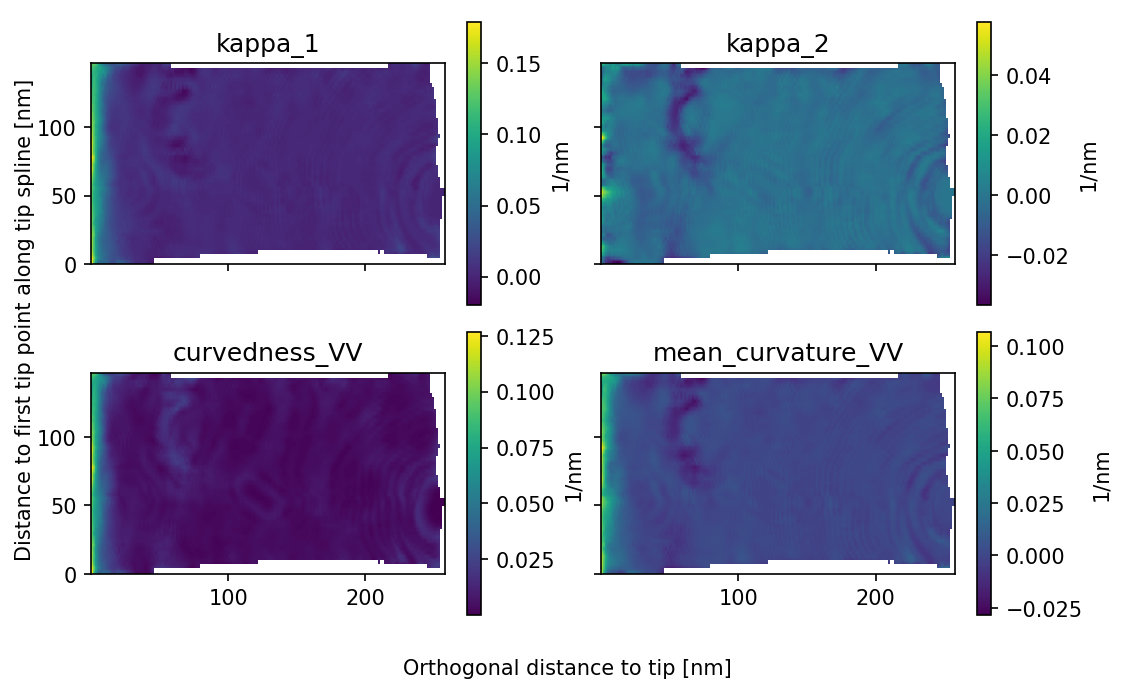

In [21]:
# Start with 2d histograms

res_dict['curv'] = {}

# For quick comparison: get some curvature parameters of tip points
res_dict['curv']['tip_point_values'] = {}

for parameter in ['kappa_1', 'kappa_2', 'curvedness_VV']:
    tip_vals = curv_mesh[parameter][tip.ids]
    print('Tip points: Mean {} is {} 1/nm, std is {} 1/nm.'.format(parameter, np.mean(tip_vals), np.std(tip_vals)))

    res_dict['curv']['tip_point_values'][parameter+'_mean'] = np.mean(tip_vals)
    res_dict['curv']['tip_point_values'][parameter+'_std'] = np.std(tip_vals)


# Make 2d histograms of curvature parameters 
hist_values = ['kappa_1', 'kappa_2', 'curvedness_VV', 'mean_curvature_VV']
H_curv, H_curv_counts, extent_curv = histogram_2d_polydata(curv_mesh, 'dist_to_tip_orth', 'dist_along_tip', hist_values, 
                                                           bin_steps=bin_steps_xy, return_bins=False, return_transposed=False)

# Plot histograms

# Calculations to get a good figure size
fig_height = 4.8
fig_aspect = 0.5*H_curv['kappa_1'].shape[0]/H_curv['kappa_1'].shape[1]
if fig_aspect > 4:
    fig_aspect=4
fig_size = (np.floor(fig_aspect*fig_height), fig_height)

fig, axes = plt.subplots(2,2,dpi=150, sharex=True, sharey=True, figsize=fig_size)

for i, ax in enumerate(fig.axes):
    n = hist_values[i]
    im = ax.imshow(H_curv[n].T, origin='lower', extent=extent_curv, cmap='viridis', aspect='equal')#, clim=[all_curv_min, all_curv_max]) 
    plt.colorbar(im, label='1/nm', ax=ax)
    ax.set_title(n)


    
fig_common_axis_labels(fig, xlabel='Orthogonal distance to tip [nm]', ylabel='Distance to first tip point along tip spline [nm]')   


### 1D histograms

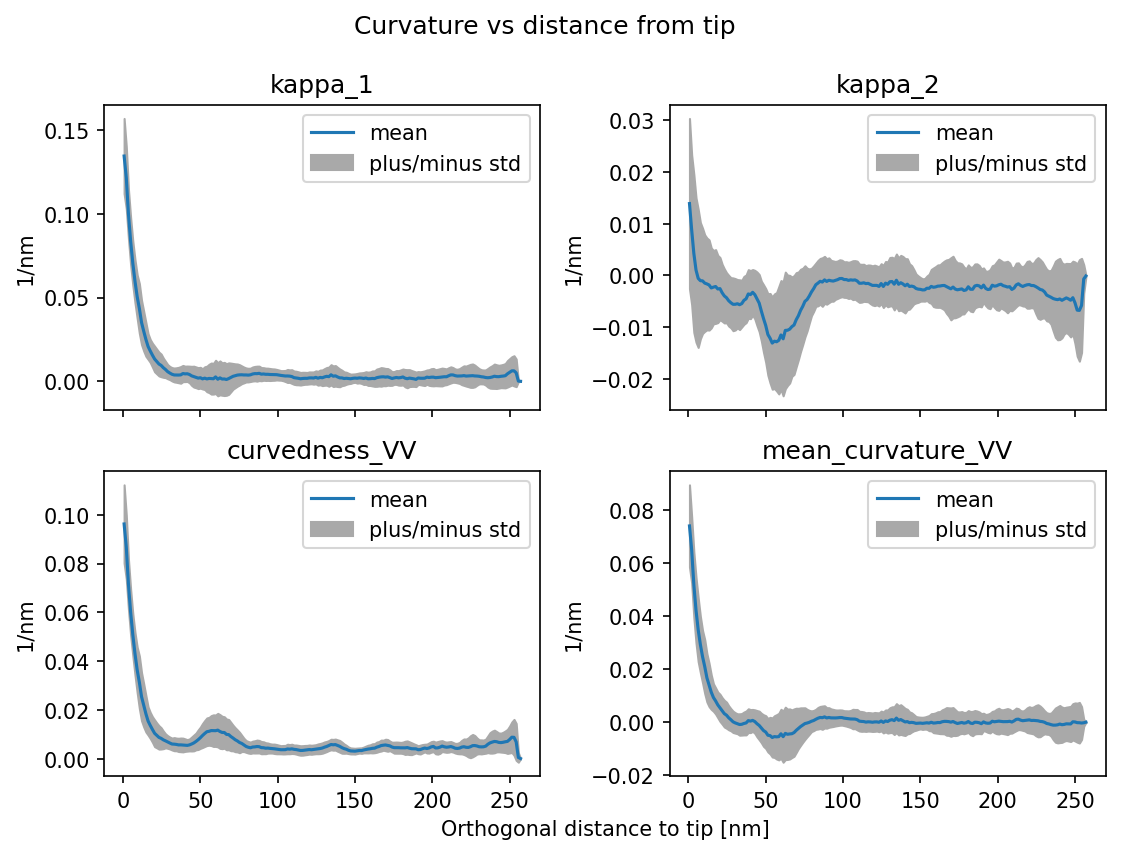

In [22]:
# H_curv_1d: Plot curvature profiles against distance to tip (1d histogram)

H_curv_1d = {}

for value_name in hist_values:
    H_curv_1d[value_name], H_curv_1d['bin_edges'], H_curv_1d['bin_ids'] = histogram_1d_statistics(curv_mesh['dist_to_tip_orth'], 
                                                                                            values=curv_mesh[value_name], 
                                                                                            bin_steps=bin_step_dist, 
                                                                                            statistics='basic')

H_curv_1d['bin_middles'] = 0.5*(H_curv_1d['bin_edges'][1:]+H_curv_1d['bin_edges'][:-1])  


fig, axes = plt.subplots(2,2,dpi=150, sharex=True, figsize=(8,6))
fig.suptitle('Curvature vs distance from tip')

for i, ax in enumerate(fig.axes):
    n = hist_values[i]    
    plot_hist1d_std(H_curv_1d['bin_middles'], H_curv_1d[n], ylabel='1/nm', title=n, ax=ax)

# Add common x label
fig_common_axis_labels(fig, xlabel='Orthogonal distance to tip [nm]')

# Save some key values from the first bin (tip bin) for easy comparison
res_dict['curv']['tip_bin_values'] = {}

for value_name in hist_values:
    for value_type in ['mean', 'std']:
        res_dict['curv']['tip_bin_values'][value_name+'_'+value_type] = H_curv_1d[value_name][value_type][0]


Detected 0 peak(s) of the curvedness along the tip.


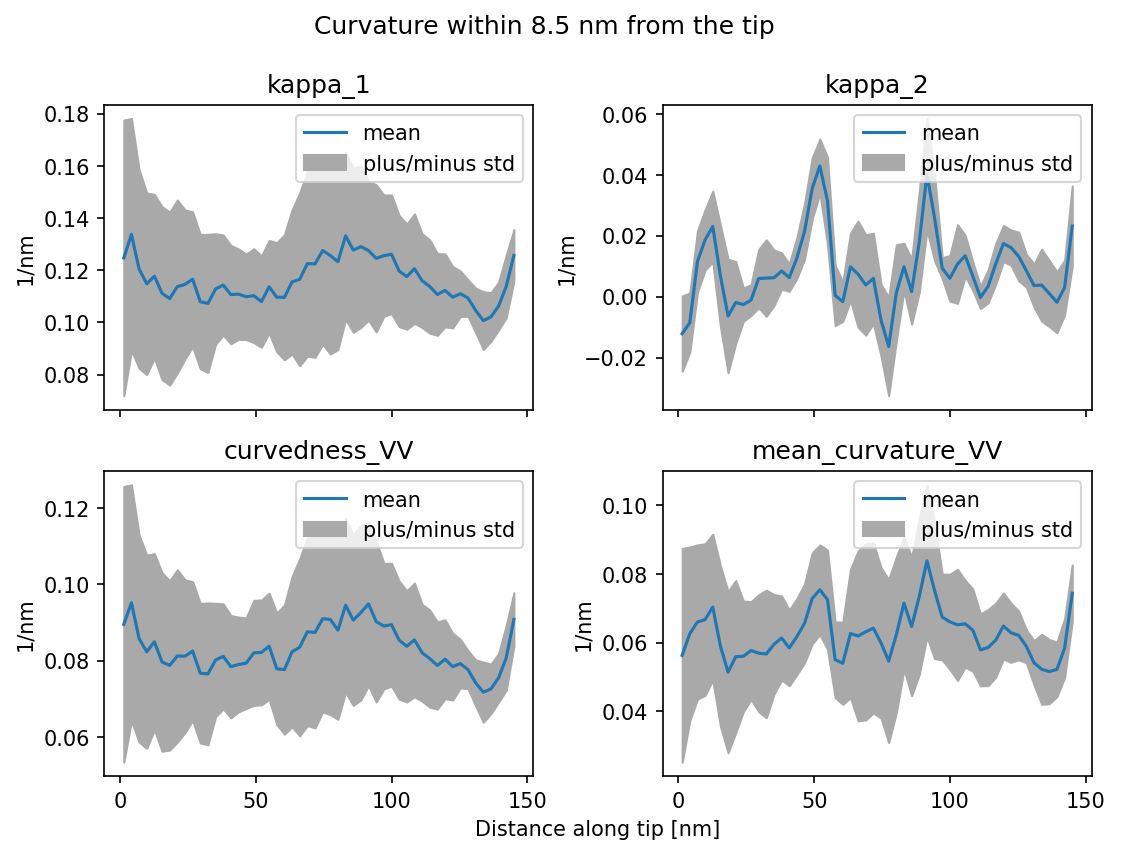

In [23]:
# H_curv_1dt: Plot curvature profiles along tip

k1_max_mean = np.max(H_curv_1d['kappa_1']['mean'])

H_curv_1dt = {}
H_curv_1dt['k1_cutoff_val'] = 0.5*k1_max_mean
H_curv_1dt['k1_cutoff_id'] = np.where(H_curv_1d['kappa_1']['mean'] <= H_curv_1dt['k1_cutoff_val'])[0][0]
H_curv_1dt['k1_cutoff_dist'] = H_curv_1d['bin_edges'][H_curv_1dt['k1_cutoff_id']+1]

high_k1_ids = np.where(H_curv_1d['bin_ids'] < H_curv_1dt['k1_cutoff_id'])[0]


for value_name in hist_values:
    H_curv_1dt[value_name], H_curv_1dt['bin_edges'], H_curv_1dt['bin_ids'] = histogram_1d_statistics(curv_mesh['dist_along_tip'][high_k1_ids], 
                                                                                            values=curv_mesh[value_name][high_k1_ids], 
                                                                                            bin_steps=bin_step_tip, 
                                                                                            statistics='basic')


H_curv_1dt['bin_middles'] = 0.5*(H_curv_1dt['bin_edges'][1:]+H_curv_1dt['bin_edges'][:-1])  

# Curvature peaks along tip: check for peaks in curvedness

# Smooth using Savitzky-Golay filter
cn_smooth = sig.savgol_filter(H_curv_1dt['curvedness_VV']['mean'], window_length=5, polyorder=2)
# Get the mean std of the curvedness: peak prominence should be higher than this
cn_mean_std = np.mean(H_curv_1dt['curvedness_VV']['std'])
# Find maxima
cn_peaks, cn_peak_props = sig.find_peaks(cn_smooth, height=0, prominence=cn_mean_std)#, width=0, rel_height=0.5)

n_cn_peaks = len(cn_peaks)
print('Detected {} peak(s) of the curvedness along the tip.'.format(n_cn_peaks))

# Plot

fig, axes = plt.subplots(2,2,dpi=150, sharex=True, figsize=(8,6))
fig.suptitle('Curvature within {:.1f} nm from the tip'.format(H_curv_1dt['k1_cutoff_dist']))

for i, ax in enumerate(fig.axes):
    n = hist_values[i]
    plot_hist1d_std(H_curv_1dt['bin_middles'], H_curv_1dt[n], ylabel='1/nm', title=n, ax=ax)

# Add common x label
fig_common_axis_labels(fig, xlabel='Distance along tip [nm]')

### Calculate bending energy

In [24]:
# Bending energy

# Estimation of the Helfrich bending energy
E_bend_tot, E_bend_local = bending_energy(curv_mesh['area'], curv_mesh['mean_curvature_VV'])  
print('Experimental bending energy: {:.2e} J.'.format(E_bend_tot))

# Also calculate bending energy per nm of rim length
L_tip = spline_distances[-1]
E_bend_per_rim_nm = E_bend_tot / L_tip
print('Bending energy per nm of rim: {:.2e} J/nm.'.format(E_bend_per_rim_nm))

# Save results
res_dict['curv']['Bending_energy'] = {}

for key in ['L_tip', 'E_bend_tot', 'E_bend_per_rim_nm']:
    res_dict['curv']['Bending_energy'][key] = locals()[key] 

Experimental bending energy: 1.32e-18 J.
Bending energy per nm of rim: 9.06e-21 J/nm.


## Save results or compare to previously saved results

In [25]:
# Turn all named tuples into dictionaries for saving
res_dict_all = namedtuple_to_dict(res_dict)
overwrite_res_dict = True


# Save dictionaries with np.save as npy files
if overwrite_res_dict:
    np.save(fname_compare, res_dict_all)
    
# Pyvista meshes with arrays can be saved using mesh.save(fname)
if save_meshes:
    for key, mesh in zip(['rim', 'mid_surf'], [curv_mesh, mid_surf]):
        fname = fnames_out_mesh[key].as_posix()
        mesh.save(fname)
        print("Saving {} mesh as {}".format(key, fname))

    

Saving rim mesh as ../example_data/rim_analysis/rim_mesh_out.vtp
Saving mid_surf mesh as ../example_data/rim_analysis/mid_surf_mesh_out.vtp


In [26]:
# Load and compare

# Load reference
res_dict_ref = np.load(fname_compare, allow_pickle=True).item()

if dicts_all_equal(res_dict_ref, res_dict_all):
    print('Results are identical to previously saved ones.')
else:
    print('Check: results are not identical with previously saved ones.')

Results are identical to previously saved ones.
